# Regularyzacja Sieci Neuronowych

Za pomocą poniższego skryptu proszę pobrać zbiór danych - jest to zmniejszona wersja MNISTa na potrzeby ćwiczenia. Jeśli sieci uczą się zbyt wolno, można spróbować dostosować parametr `shrinkage`. Mówi on o tym, jak duża część zbioru danych jest wczytywana.

In [61]:
import torch
from checker import test_bn, test_droput
from utils import ModelTrainer, load_mnist, show_results

%matplotlib inline


torch.manual_seed(44)

train_dataset = load_mnist(train=True, shrinkage=0.01)
test_dataset = load_mnist(train=False, shrinkage=0.1)

Poniższy blok ustawia parametry wspólne dla wszystkich porównywanych w notebooku modeli. Powinny być one ustawione tak, aby wszystkie modele zdążyły się nauczyć zadania do granic swoich możliwości (wypłaszczenie funkcji kosztu) - zaproponowane parametry powinny być w porządku, ale modele mogą liczyć się powoli.

In [62]:
n_epochs = 300
learning_rate = 0.05
batch_size = 128

trainer = ModelTrainer(train_dataset, test_dataset, batch_size=batch_size)

Następnie przy użyciu modułu `torch.nn.Sequential`, który tworzy sieć neuronową przez sekwencyjne łączenie podanych warstw, budujemy sieć neuronową z 2 warstwami ukrytymi o wielkości 256 i aktywacją ReLU między nimi. Sieć ta posłuży nam jako baseline, a w dalszej części notebooka będziemy dodawać do modelu dodatkowe warstwy i porównywać wyniki.

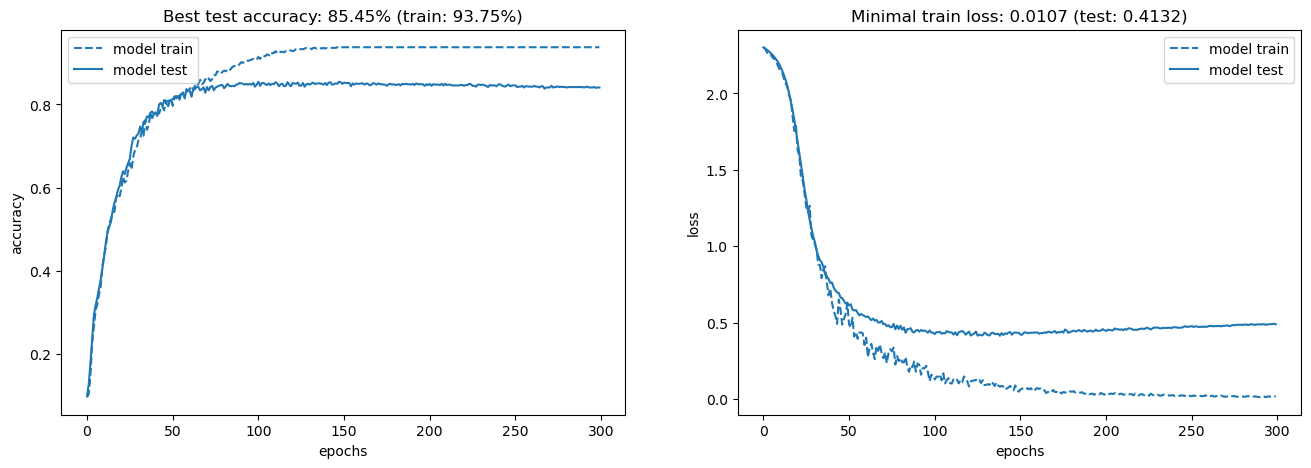

In [63]:
model = torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10),
)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
history = trainer.train(model, optimizer, n_epochs=n_epochs)
show_results(model=history)

Sieć osiąga około 85,5% dokładności $^*$ na zbiorze testowym. Na wykresie funkcji kosztu widać, że krzywa testowa w okolicach 100-tnej epoki $^*$ zaczyna się unosić, a dokładność przestaje rosnąć. Świadczy to o tym, że model zaczyna za bardzo dopasowywać się do danych (**overfitting**). Aby otrzymać najlepszy model dla tej architektury, należałoby wczytać parametry z momentu, gdy dokładność testowa była najwyższa (tzw. **early stopping**). W dalszej części rozważymy architektury z regularyzacjami poprawiającymi ten wynik.

$^*$ liczby dotyczą proponowanych domyślnych parametrów

### Regularyzacje Oparte o Funkcję Kosztu

Podstawowym sposobem regularyzacji, w którym nie ingerujemy w architekturę, jest dodanie do funkcji kosztu $J(\Theta;X,y)$ kary $\Omega(\Theta)$ związanej z parametrami. Kara jest regulowana przez współczynnik $\alpha \in [0, \infty)$.

\begin{equation*}
\tilde{J}(\Theta;X,y) = J(\Theta;X,y) + \alpha \Omega(\Theta)
\end{equation*}

Podstawowym wyborem przy doborze kary jest norma **L1** lub **L2** na wagach sieci. Zwykle dążymy do uproszczenia modelu, a więc zmniejszenia wariancji, dlatego **norma jest stosowana tylko na wagach, z pominięciem biasów**.

### Zadanie 1. Dropout (3 pkt.)

Dropout jest warstwą „wyłączającą” część neuronów, przez co model staje się bardziej odporny na overfitting.

![image.png](https://raw.githubusercontent.com/gmum/ml2024-25/main/lab/resources/dropout.png)

Pytania: 

1. Jaka intuicja regularyzacyjna stoi za pozostawieniem tylko części cech w trakcie nauki?
2. Co można powiedzieć o krzywej dokładności na zbiorze treningowym z użyciem Dropoutu w porównaniu do modelu baseline'owego?
3. W jaki sposób sieć z warstwą dropout można traktować jako ensemble (połączenie wielu modelów)?
4. Dlaczego powinniśmy skalować aktywacje o stałą w treningu lub w teście?

**Odpowiedź na powyższe pytania jest częścią zadania. W poszukiwaniu odpowiedzi należy się posiłkować oryginalną publikacją wprowadzającą Dropout [1].**


Hint do implementacji: [`torch.bernoulli`](https://pytorch.org/docs/stable/torch.html#torch.bernoulli). 
**Zakładamy, że chcemy wykonywać skalowanie w treningu.**
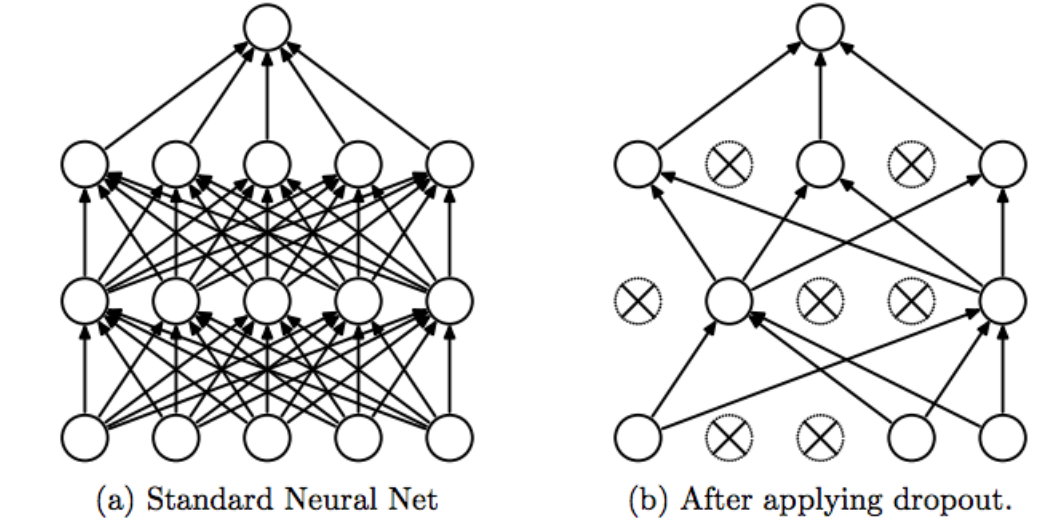

1. Stosowanie wielkich sieci neuronowych jest ciężkie, ze względu na liczbę parametrów oraz czas treningu. W celu zmniejszenia overfittingu, można używać kilku sieci neuronowych, jednak utrzymywanie kilku wielkich sieci neuronowych sprawia, że jest to niekorzystne czasowo. Pozostawianie tylko części cech w trakcie nauki sprawia, że cały ten proces jest prostszy w utrzymaniu i szybszy.
2. Dokładność na zbiorze treningowym będzie mniejsza, ponieważ poprzez wyłączanie neuronów zmniejszamy możliwość sieci do dopasowania się do danych. Spadek ten jednak jest pożądany, ponieważ zmniejsza ryzyko overfittingu
3. Model pełnej sieci neuronowej po zastosowaniu warstwy dropout staje się jednym z 2^n^ możliwych podsieci neuronowych danej sieci (wyrzucamy losowy podzbiór neuronów n). W każdej iteracji treningu tworzona jest nowa podsieć, w takim razie cały proces treningu może być interpretowany jako trening 2^n^ modeli, które mają wspólne wagi
4. Skalowanie daje nam pewność, że oczekiwany output dla każdego ukrytego neuronu jest taki sam jak faktyczny output. Dzięki skalowaniu 2^n^ podsieci może być złożonych w jedną sieć, która będzie wykorzystywana w czasie testowania.

In [64]:
class Dropout(torch.nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()

        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.bernoulli(torch.ones_like(x) * (1 - self.p)).float()
            return mask * x / (1.0 - self.p)

        else:
            return x

In [65]:
test_droput(Dropout)

Do modelu baseline'owego po każdej warstwie należy dodać dropout z prawdopodobieństwem zachowania neuronów równym 50%. (można eksperymentować z niestandardowymi wartościami)

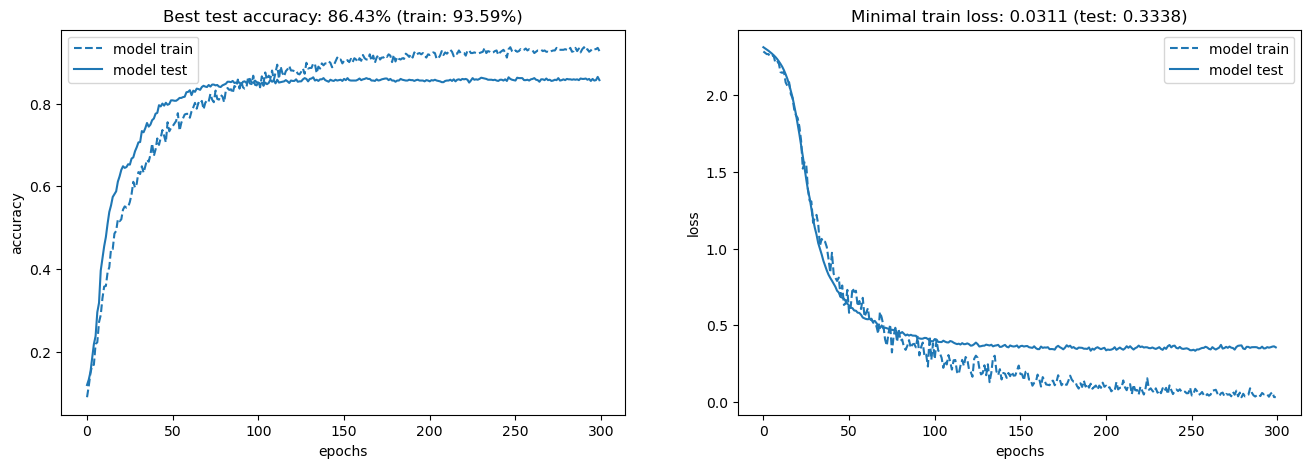

In [66]:
model = torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    Dropout(0.3),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    Dropout(0.5),
    torch.nn.Linear(256, 10),
)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
dropout_history = trainer.train(model, optimizer, n_epochs=n_epochs)
show_results(model=dropout_history)

### Zadanie 2. Batch Normalization (4 pkt.)

Batch Normalization jest techniką redukującą **internal covariate shift (przesunięcie rozkładu danych)** (ale czy na pewno? [[3]](https://arxiv.org/pdf/1805.11604.pdf)) poprzez normalizację wyjścia poszczególnych warstw. Wraz ze zmianą parametrów warstwy poprzedniej zmienia się domena zadania dla warstwy kolejnej. Dzięki normalizacji uczenie jest szybsze i bardziej stabilne - można użyć wyższych wartości współczynnika uczenia, normalizacja redukuje zanikanie i wybuchanie gradientów.

**Oznaczenia:**
* $ x_i $ - wektor z wejścia $x$ do warstwy BatchNorm
* $ y_i $ - wektor z wyjścia $y$ z warstwy BatchNorm
* $ \gamma $ - *scale*, uczony parametr, inicjalizowana na ???
* $ \beta $ - *shift*, uczony parametr, inicjalizowana na ???
* $ \overline{\mu} $ - średnia krocząca średniej batcha, inicjalizowana na ???
* $ \overline{\sigma} $ - średnia krocząca wariancji batcha, inicjalizowana na ???
* $\lambda$ - momentum do średnich kroczących



<font size=2> $$ \mu_B  = \frac{1}{m} \sum_{i=1}^m x_i $$ </font>
<font size=2>$$ \sigma^2_B  = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_b)^2 $$ </font>
<font size=2> $$ \hat{x_i} = \frac{x_i - \mu_B}{\sqrt{\sigma^2_B + \epsilon}} $$ </font>
<font size=2> $$ y_i = \gamma \hat{x_i} + \beta $$ </font>

Dodatkowo potrzebujemy:

<font size=2> $$ \overline{\mu}_{t+1} =  (1 - \lambda) \overline{\mu}_{t} + \lambda \mu_B $$ </font>
<font size=2> $$ \overline{\sigma^2}_{t+1} =  (1 - \lambda) \overline{\sigma^2}_{t} + \lambda \sigma^2_B $$ </font>

**Pytania:**
1. Jak BN może zapobiegać zanikającym gradientom? Wytłumaczyć na przykładzie aktywacji sigmoidalnej $\sigma(x) = \frac{1}{1+e^{-x}}$.
2. Czy BN powinien być stosowany przed czy po aktywacji i dlaczego? (Wskazówka: nie ma złych odpowiedzi)
3. Czy można BN traktować jako regularyzację sieci neuronowej? Dlaczego?


**Odpowiedź na powyższe pytania jest częścią zadania. W poszukiwaniu odpowiedzi należy się posiłkować publikacjami dotyczącymi batch normalization [2, 3].**

1. BN może zapobiegać zanikającym gradientom stabilizując rozkład wejść do każdej warstwy. Dla funkcji sigmoidalnej: dla dużych wartości bezwzględnych x, g'(x) -> 0, co powoduje, że gradienty przepływające wstecz zaczynają zanikać, prowadząc do wolniejszej nauki modelu. BN normalizuje wejścia x do warstwy, aby wartości miały stabilniejszy rozkład, co zapobiega temu, aby większość wartości x była w regionach, gdzie pochodna funkcji sigmoidalnej jest bliska 0
2. BN przed aktywacją: stosowany na surowych wartościach z = Wu + b, co oznacza że wejście do warstw ma bardziej stabilny rozkład. 
Stosowanie BN po aktywacji sprawia, że te dane stają się znormalizowane. Może to być korzystne dla funkcji aktywacji, która ogranicza wartości (np. sigmoid do 0-1).
3. Dzięki normalizacji wejść w trakcie treningu, BN sprawia, że sieć staje się mniej wrażliwa na zmiany poszczególnych parametrów (podobnie jak standardowa regularyzacja - model staje się mniej dopasowany do danych treningowych). Jednak głównym celem BN jest stabilizacja procesu uczenia i przyspieszenie zbieżności.

In [67]:
class BatchNorm(torch.nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm, self).__init__()

        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        self.mu = torch.zeros(num_features)
        self.sigma = torch.ones(num_features)
        
        self.gamma = torch.nn.Parameter(torch.ones(num_features))
        self.beta = torch.nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=0)
            var = ((x - mean) ** 2).mean(dim=0)
            x_hat = (x - mean) / torch.sqrt(var + self.eps)
            self.mu = (1.0 - self.momentum) * self.mu + self.momentum * mean
            self.sigma = (1.0 - self.momentum) * self.sigma + self.momentum * var
            return self.gamma * x_hat + self.beta

        else:
            x_hat = (x - self.mu) / torch.sqrt(self.sigma + self.eps)
            return self.gamma * x_hat + self.beta

In [68]:
test_bn(BatchNorm)

Do modelu baseline'owego należy dodać Batch Normalization po każdej warstwie.

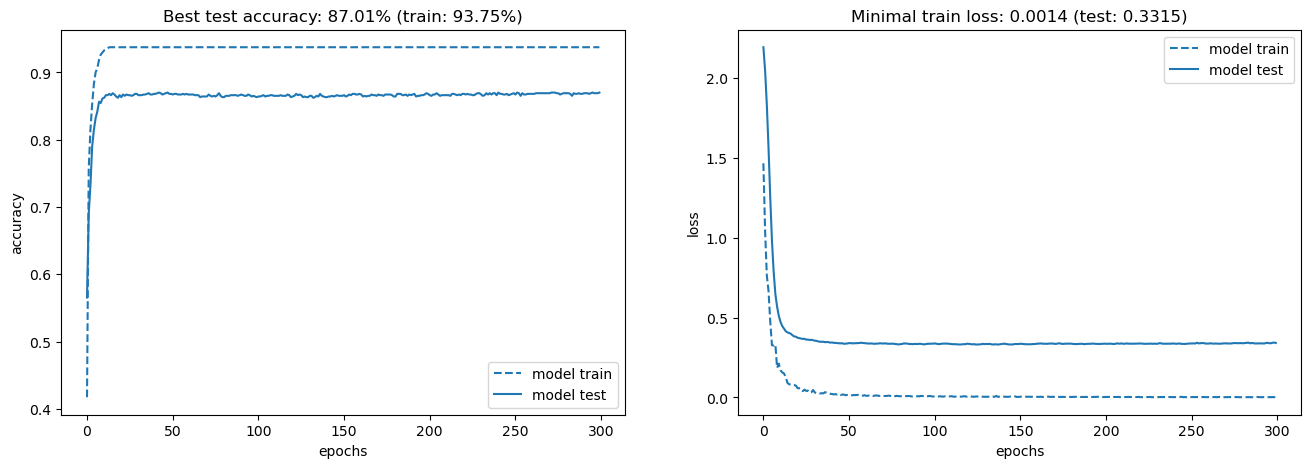

In [69]:
model = torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    BatchNorm(256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    BatchNorm(256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10),
)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
bn_history = trainer.train(model, optimizer, n_epochs=n_epochs)
show_results(model=bn_history)

### Podsumowanie

Poniżej załączony oczekiwany rezultat eksperymentów dla zaproponowanych parametrów.

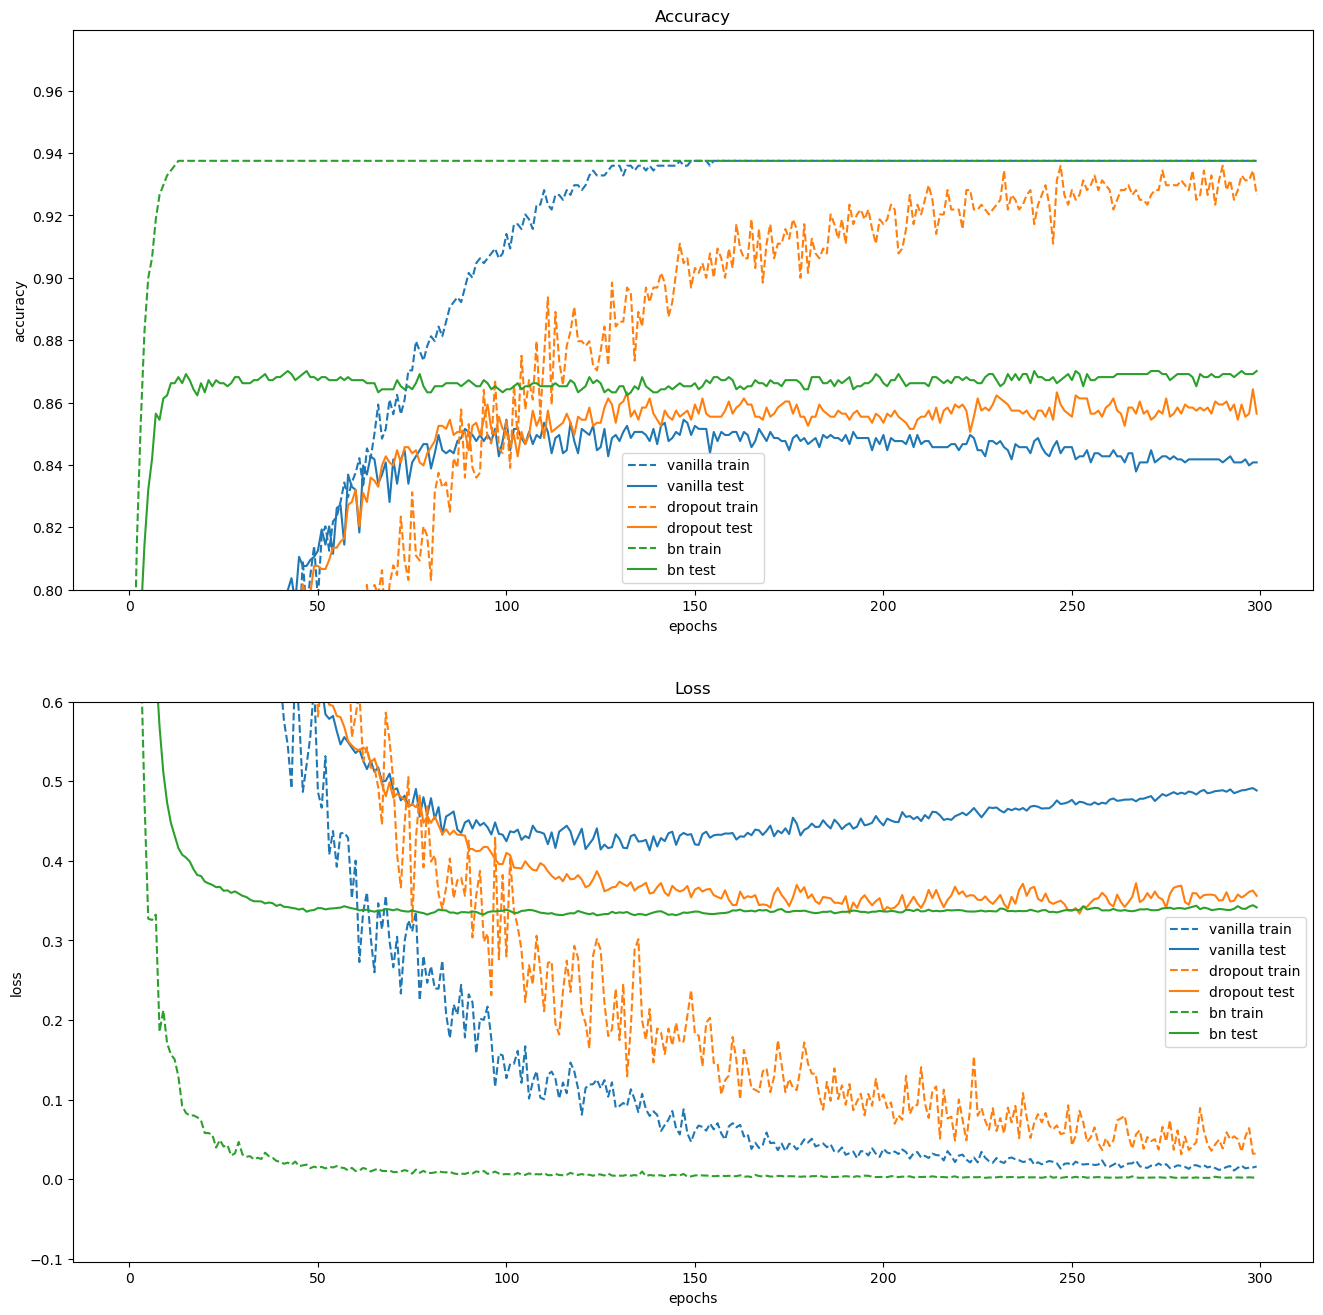

In [70]:
show_results(
    vanilla=history,
    dropout=dropout_history,
    bn=bn_history,
    orientation="vertical",
    accuracy_bottom=0.8,
    loss_top=0.6,
)

### Literatura
 
1. [Srivastava, Nitish, et al. "Dropout: a simple way to prevent neural networks from overfitting."](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

2. [Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift."](https://arxiv.org/pdf/1502.03167.pdf)

3. [Santurkar, Shibani, et al. "How does batch normalization help optimization?(no, it is not about internal covariate shift)."](https://arxiv.org/pdf/1805.11604.pdf)